# Evaluation notebook for [CryCeleb2023 challenge](https://huggingface.co/spaces/competitions/CryCeleb2023)

## This notebook does the following:
- Download the Cryceleb data from Hugging Face.
- Download a pretrained SpeechBrain model from Hugging Face.
- Compute embeddings.
- Compute similarity scores for pairs of embeddings.
- Compute the equal error rate of the scores and visualize results.
- Produces my_solution.csv that can be uploaded to the competition platform.

### Imports

In [ ]:
# For Colab - uncomment and run the following to set up the repo
# !pip install speechbrain
# !git clone https://github.com/Ubenwa/cryceleb2023.git
# %cd cryceleb2023

In [1]:
%%capture

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import speechbrain as sb
import torch
import random
from huggingface_hub import hf_hub_download
from IPython.display import display
from speechbrain.dataio.dataio import read_audio
from speechbrain.pretrained import EncoderClassifier, SpeakerRecognition
from speechbrain.utils.metric_stats import EER
from tqdm.notebook import tqdm

from crybrain import download_data

dataset_path = "data"

/home/siddhant2021565/miniconda3/envs/COMPARE/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


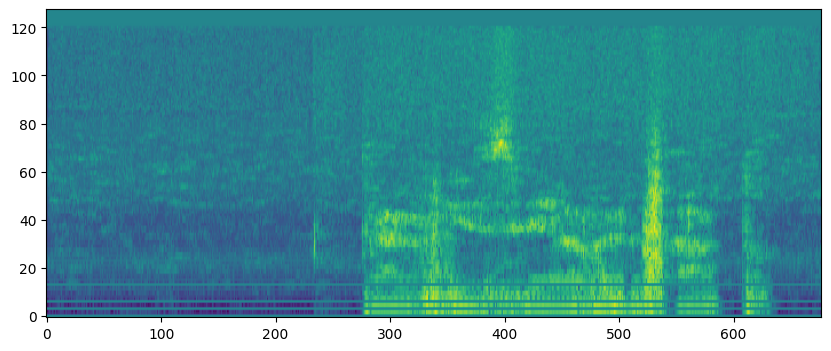

In [3]:
import torchaudio

signal, sr = torchaudio.load('/home/siddhant2021565/DATASET/emotions/raw/wav/23555.wav')
mel_specgram = torchaudio.transforms.MelSpectrogram()(signal)
mel_specgram = mel_specgram.squeeze(0).numpy()
mel_specgram = np.log(mel_specgram+1e-5)

mel_specgram -= np.mean(mel_specgram, axis = 1).reshape(-1, 1)
plt.figure(figsize=(10, 4))
plt.imshow(mel_specgram, cmap = 'viridis', aspect = 'auto', origin = 'lower')
plt.show()

#display the mel spectrogram

### Data

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
download_data(dataset_path)

In [2]:
# read metadata
metadata = pd.read_csv(
    f"{dataset_path}/metadata.csv", dtype={"baby_id": str, "chronological_index": str}
)
dev_metadata = metadata.loc[metadata["split"] == "dev"].copy()
# read sample submission
sample_submission = pd.read_csv(
    f"{dataset_path}/sample_submission.csv"
)  # scores are unfiorm random
# read verification pairs
dev_pairs = pd.read_csv(
    f"{dataset_path}/dev_pairs.csv", dtype={"baby_id_B": str, "baby_id_D": str}
)
test_pairs = pd.read_csv(f"{dataset_path}/test_pairs.csv")

display(
    metadata.head()
    .style.set_caption("metadata")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)
display(
    dev_pairs.head()
    .style.set_caption("dev_pairs")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)
display(
    test_pairs.head()
    .style.set_caption("test_pairs")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)
display(
    sample_submission.head()
    .style.set_caption("sample_submission")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)

,baby_id,period,duration,split,chronological_index,file_name,file_id
0,0694,B,1.320000,dev,000,audio/dev/0694/B/0694_B_000.wav,0694_B_000
1,0694,B,0.940000,dev,001,audio/dev/0694/B/0694_B_001.wav,0694_B_001
2,0694,B,0.880000,dev,002,audio/dev/0694/B/0694_B_002.wav,0694_B_002
3,0694,B,1.130000,dev,003,audio/dev/0694/B/0694_B_003.wav,0694_B_003
4,0694,B,1.180000,dev,004,audio/dev/0694/B/0694_B_004.wav,0694_B_004


,baby_id_B,baby_id_D,id,label
0,0133,0611,0133B_0611D,0
1,0593,0584,0593B_0584D,0
2,0094,0292,0094B_0292D,0
3,0563,0094,0563B_0094D,0
4,0122,0694,0122B_0694D,0


,baby_id_B,baby_id_D,id
0,anonymous027,anonymous212,anonymous027B_anonymous212D
1,anonymous035,anonymous225,anonymous035B_anonymous225D
2,anonymous029,anonymous288,anonymous029B_anonymous288D
3,anonymous001,anonymous204,anonymous001B_anonymous204D
4,anonymous075,anonymous244,anonymous075B_anonymous244D


,id,score
0,anonymous027B_anonymous212D,0.548814
1,anonymous035B_anonymous225D,0.715189
2,anonymous029B_anonymous288D,0.602763
3,anonymous001B_anonymous204D,0.544883
4,anonymous075B_anonymous244D,0.423655


### Initialize encoder

One way to verify if both pairs come from the same baby is to concatenate all the segments for each pair, compute the embedding of the concatenated cry, and compute the cosine similarity between the embeddings.

Let's load the model

In [ ]:
!rm -rf spkrec-ecapa-voxceleb
encoder = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="spkrec-ecapa-voxceleb",
    run_opts={"device": "cuda"},  # comment out if no GPU available
)

In [5]:
# you can also plug in your encoder weights if you fine-tuned this model locally
!rm -rf spkrec-ecapa-voxceleb/
!mkdir spkrec-ecapa-voxceleb
!cp experiments/ecapa_voxceleb_ft_basic/ckpts/CKPT+epoch-958_valacc-10.00/embedding_model.ckpt spkrec-ecapa-voxceleb/embedding_model.ckpt
!cp experiments/ecapa_voxceleb_ft_basic/ckpts/CKPT+epoch-958_valacc-10.00/compute_features.ckpt spkrec-ecapa-voxceleb/compute_features.ckpt
encoder = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="spkrec-ecapa-voxceleb",
    run_opts={"device": "cuda"},  # comment out if no GPU available
 )

cp: cannot stat 'experiments/ecapa_voxceleb_ft_basic/ckpts/CKPT+epoch-958_valacc-10.00/embedding_model.ckpt': No such file or directory
cp: cannot stat 'experiments/ecapa_voxceleb_ft_basic/ckpts/CKPT+epoch-958_valacc-10.00/compute_features.ckpt': No such file or directory


In [3]:
from crybrain import CryBrain
from hyperpyyaml import load_hyperpyyaml

config_filename = "hparams/ecapa_voxceleb_basic.yaml"
overrides = {
    "seed": 3011,
    "n_classes": 626,
    "experiment_name": "ecapa_voxceleb_ft_basic",
    "bs": 32,
    "n_epochs": 50,
}
device = "cuda:0"
run_opts = {"device": device}
###########################################
# Load hyperparameters file with command-line overrides.
with open(config_filename) as fin:
    hparams = load_hyperpyyaml(fin, overrides)

model = CryBrain(
    modules=hparams["modules"], hparams=hparams, run_opts=run_opts, checkpointer=None
)

model.modules.embedding_model.load_state_dict(torch.load("experiments/ecapa_voxceleb_ft_basic/ckpts/CKPT+epoch-999_valacc-5.00/embedding_model.ckpt"))
model.modules.embedding_model.eval()
model.modules.compute_features.load_state_dict(torch.load("experiments/ecapa_voxceleb_ft_basic/ckpts/CKPT+epoch-999_valacc-5.00/compute_features.ckpt"))

setting seeds to 3011
setting cuda seeds to 3011
lrsched_name: cyclic


<All keys matched successfully>

In [5]:
model.modules.compute_features

SincConv()

In [4]:
def shuffle_group_and_concat(x, n=5):
    concatenated_results = []
    for _ in range(n):
        shuffled_values = x.values.copy()
        random.shuffle(shuffled_values)
        concatenated = np.concatenate(shuffled_values)
        concatenated_results.append(concatenated)
    return concatenated_results

#### Compute Encodings

Change runtime type to GPU if using Colab

In [10]:
%%time
# read the segments
dev_metadata = metadata.loc[metadata['split']=='dev'].copy()
dev_metadata['cry'] = dev_metadata.apply(lambda row: read_audio(dataset_path+'/'+row['file_name']).numpy(), axis=1)
grouped_data = dev_metadata.groupby(['baby_id', 'period'])['cry']
cry_dict = {}
for key, group in grouped_data:
    cry_dict[key] = {'cry': shuffle_group_and_concat(group, 5)}
    
for (baby_id, period), d in tqdm(cry_dict.items()):
    cry_array = d['cry']
    cry_encoded_list = []

    for row in cry_array:
        with torch.no_grad():
            with torch.cuda.amp.autocast(dtype=torch.float16):
                feats = model.modules.compute_features(torch.tensor(row).unsqueeze(0).to('cuda:0').type(torch.float16))
                feats = model.modules.mean_var_norm(feats, torch.tensor([feats.shape[1]]))
                encoded_row = model.modules.embedding_model(feats)
                print(encoded_row.shape)
                cry_encoded_list.append(encoded_row)

    d['cry_encoded'] = cry_encoded_list
dev_pairs['score'] = dev_pairs.apply(lambda row: compute_cosine_similarity_score(row=row, cry_dict=cry_dict), axis=1)

  0%|          | 0/80 [00:00<?, ?it/s]

torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1, 192])
torch.Size([1, 1

#### Compute Similarity Between Encodings

In [12]:
def compute_cosine_similarity_score(row, cry_dict):
    """ Average scores for all possible pairs """
    cos = torch.nn.CosineSimilarity(dim=-1)
    encoded_cry_B = cry_dict[(row['baby_id_B'], 'B')]['cry_encoded']
    encoded_cry_D = cry_dict[(row['baby_id_D'], 'D')]['cry_encoded']
    
    similarity_scores = []
    for tensor_B in encoded_cry_B:
        for tensor_D in encoded_cry_D:
            similarity_score = cos(tensor_B, tensor_D)
            similarity_scores.append(similarity_score.item())
    
    return sum(similarity_scores) / len(similarity_scores)


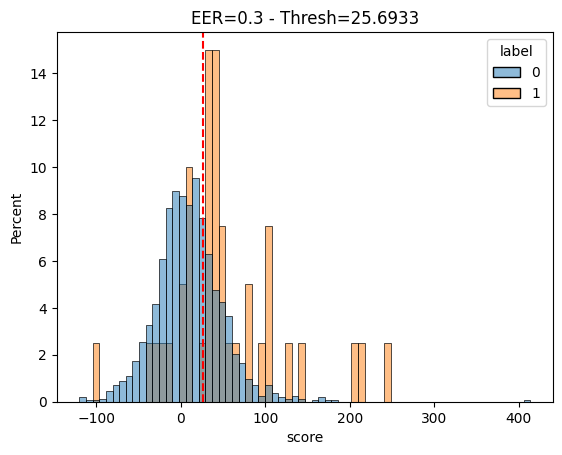

In [11]:
def compute_eer_and_plot_verification_scores(pairs_df):
    """pairs_df must have 'score' and 'label' columns"""
    positive_scores = pairs_df.loc[pairs_df["label"] == 1]["score"].values
    negative_scores = pairs_df.loc[pairs_df["label"] == 0]["score"].values
    eer, threshold = EER(torch.tensor(positive_scores), torch.tensor(negative_scores))
    ax = sns.histplot(pairs_df, x="score", hue="label", stat="percent", common_norm=False)
    ax.set_title(f"EER={round(eer, 4)} - Thresh={round(threshold, 4)}")
    plt.axvline(x=[threshold], color="red", ls="--")
    return eer, threshold


eer, threshold = compute_eer_and_plot_verification_scores(pairs_df=dev_pairs)

The above plot displays the histogram of scores for +ive (same baby) and -ive (different baby) dev_pairs.\
A perfect verifier would attribute a higher score to all +ive pairs than any -ive pair.\
Your task is to come up with a scoring system which maximizes the separation between the two distributions, as measured by the EER.\
You can change the encoder module, the aggregation of cry segments, the similarity metric, or come up with a completely different process! \
You will be evaluated on the test_pairs.csv, for which ground truth labels are not provided.




Score the test_pairs and submit:



In [15]:
%%time
test_metadata = metadata.loc[metadata['split']=='test'].copy()
test_metadata['cry'] = test_metadata.apply(lambda row: read_audio(dataset_path+'/'+row['file_name']).numpy(), axis=1)
grouped_data = test_metadata.groupby(['baby_id', 'period'])['cry']
cry_dict_test = {}
for key, group in grouped_data:
    cry_dict_test[key] = {'cry': shuffle_group_and_concat(group, 5)}
for (baby_id, period), d in tqdm(cry_dict_test.items()):
    cry_array = d['cry']
    cry_encoded_list = []

    for row in cry_array:
        with torch.no_grad():
            with torch.cuda.amp.autocast(dtype=torch.float16):
                feats = model.modules.compute_features(torch.tensor(row).unsqueeze(0).to('cuda:0').type(torch.float16))
                feats = model.modules.mean_var_norm(feats, torch.tensor([feats.shape[1]]))
                encoded_row = model.modules.embedding_model(feats)
                cry_encoded_list.append(encoded_row)

    d['cry_encoded'] = cry_encoded_list
test_pairs['score'] = test_pairs.apply(lambda row: compute_cosine_similarity_score(row=row, cry_dict=cry_dict_test), axis=1)


  0%|          | 0/320 [00:00<?, ?it/s]

CPU times: user 9min 56s, sys: 9.2 s, total: 10min 6s
Wall time: 1min 4s


In [16]:
# submission must match the 'sample_submission.csv' format exactly
my_submission = test_pairs[["id", "score"]]
my_submission.to_csv("my_submission.csv", index=False)
display(my_submission.head())

,id,score
0,anonymous027B_anonymous212D,-0.004342
1,anonymous035B_anonymous225D,-0.026720
2,anonymous029B_anonymous288D,0.165620
3,anonymous001B_anonymous204D,0.114384
4,anonymous075B_anonymous244D,0.070589


You can now download `my_submission.csv` and submit it to the challenge!